# Choice of the model

In [ ]:
# Read readme.md from github# Train the model
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Challenge_1/"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Challenge_1


## Import Python packages

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
import gc
import time
import pickle

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["MPLCONFIGDIR"] = os.getcwd() + "/configs/"
# Train the model# Train the model
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

import numpy as np

np.random.seed(seed)

import logging

import random

random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
import seaborn as sns

2.14.0


In [ ]:
IMG_SIZE = 224

### Preproces input


We create a preprocess function wich can adapt to the models in the dictionnary

In [ ]:
preprocess_functions = {"EfficientNetB0": tf.keras.applications.efficientnet.preprocess_input, "MobileNetV2": tf.keras.applications.mobilenet_v2.preprocess_input,
                        "ResNet50V2": tf.keras.applications.resnet_v2.preprocess_input, "DenseNet": tf.keras.applications.densenet.preprocess_input,
                          "InceptionResNetV2": tf.keras.applications.inception_resnet_v2.preprocess_input}

def proc_input(X_input, model_name):
    X_input = tfkl.Resizing(IMG_SIZE, IMG_SIZE)(X_input)
    X_input = tf.cast(X_input, tf.float32)
    X_input = preprocess_functions[model_name](X_input)
    return X_input


# X_test = proc_input(X_test)  ## See last function


In [ ]:
def populate_dataset(originalDataset: np.ndarray, augmentMethodDict: dict, wantedSize:int) -> np.ndarray:
  # Calculate the sum of the values in the dictionary,
  total_prob = np.sum(list(augmentMethodDict.values()))

  # Check if the sum is not equal to 1 (with some tolerance for floating-point precision)
  if not np.isclose(total_prob, 1.0):
      # Normalize the values in the dictionary to make the sum equal to 1
      augmentMethodDict = {key: value / total_prob for key, value in augmentMethodDict.items()}

  print(augmentMethodDict)

  diff = wantedSize - len(originalDataset)

  for AugFunct, percentage in augmentMethodDict.items():
    number_of_images = int(percentage * diff)
    random_indices = np.random.choice(len(originalDataset), number_of_images, replace=False)
    random_elements = originalDataset[random_indices]
    augmented_images = AugFunct(random_elements)
    originalDataset = np.concatenate((originalDataset, augmented_images))

  if len(originalDataset) < wantedSize:
    diff = wantedSize - len(originalDataset)
    random_indices = np.random.choice(len(originalDataset), diff, replace=False)
    random_elements = originalDataset[random_indices]
    originalDataset = np.concatenate((originalDataset, random_elements))

  if len(originalDataset) > wantedSize:
    originalDataset = originalDataset[:wantedSize]

  return originalDataset

In [ ]:
flip = tf.keras.Sequential(
    [
        tfkl.RandomFlip("horizontal"),
    ]
)

translation = tf.keras.Sequential(
    [
        tfkl.RandomTranslation(0.2, 0.2),
    ]
)

rotation = tf.keras.Sequential(
    [
        tfkl.RandomRotation(0.2),
    ]
)


augmentMethodDict = {
    flip: 0.3,
    translation: 0.3,
    rotation: 0.4,
}


### Callbacks

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=4,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8)

calbacks = [reduce_lr, early_stopping]

In [ ]:
img_augmentation = tfk.Sequential(
    [
        tfk.layers.RandomRotation(factor=0.15),
        tfk.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tfk.layers.RandomFlip(),
    ],
    name="img_augmentation",
)

In [ ]:
def prepare_data(model_name):
    dataset = np.load('new_dataset2.npz', allow_pickle=True) #If you are running it using Colab
    images = dataset['data']
    labels = dataset['labels']

    # Extract classes separately
    healthy_labels = np.where(labels == "healthy")[0]
    unhealthy_labels = np.where(labels == "unhealthy")[0]

    healthy_images = images[healthy_labels]
    unhealthy_images = images[unhealthy_labels]

    X = np.concatenate([healthy_images, unhealthy_images], axis=0)
    y = np.concatenate([np.zeros(len(healthy_images)), np.ones(len(unhealthy_images))], axis=0)

    # Split data into train_val and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, random_state=seed, test_size=0.2, stratify=y
    )

    # Further split train_val into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val,
        y_train_val,
        random_state=seed,
        test_size=0.2,
        stratify=y_train_val,
    )

    X_train = proc_input(X_train,model_name=model_name)
    X_val = proc_input(X_val,model_name=model_name)

    X_train = X_train.numpy()
    # Seperate the healthy and unhealthy images
    healthy_images = X_train[np.where(y_train == 0)[0]]
    unhealthy_images = X_train[np.where(y_train == 1)[0]]

    #healthy_images = tf.convert_to_tensor(populate_dataset(healthy_images, augmentMethodDict, len(healthy_images)))
    unhealthy_images = tf.convert_to_tensor(populate_dataset(unhealthy_images, augmentMethodDict, len(healthy_images)))
    print(healthy_images.shape)
    print(unhealthy_images.shape)
    # Concatenate the healthy and unhealthy images
    X_train = tf.concat([healthy_images, unhealthy_images], axis=0)

    # Create the labels healthy and unhealthy
    healthy_labels = tf.convert_to_tensor([0] * len(healthy_images))
    unhealthy_labels = tf.convert_to_tensor([1] * len(unhealthy_images))
    y_train = tf.concat([healthy_labels, unhealthy_labels], axis=0)

    # Shuffle the data
    # Shuffle the data wich is an np.array
    X_train, y_train = tf.random.shuffle(X_train, seed=seed), tf.random.shuffle(y_train, seed=seed)

    # Free up memory to avoid crashing
    del dataset
    del images
    del labels
    del healthy_images
    del unhealthy_images
    del healthy_labels
    del unhealthy_labels
    del X_train_val
    del X_test
    del y_train_val
    del y_test
    gc.collect()

    return X_train, y_train,X_val, y_val

## Train each model

We create a dictionnary that contain the models that we want to test

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import InceptionResNetV2

# Dictionnary of models to test
models = {"EfficientNetB0": EfficientNetB0, "MobileNetV2": MobileNetV2, "ResNet50V2": ResNet50V2,
          "DenseNet": DenseNet169, "InceptionResNetV2": InceptionResNetV2}

frozen_learning_rate = 1e-2
unfrozen_learning_rate = 1e-4

In [ ]:
def build_model(num_classes,model_name):

    inputs = tfk.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = models[model_name](include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tfk.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tfk.layers.BatchNormalization()(x)

    x = tfk.layers.Dropout(0.3, name="top1_dropout")(x)
    x = tfk.layers.Dense(10, activation="relu")(x)
    x = tfk.layers.BatchNormalization()(x)

    outputs = tfk.layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")

    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = ["accuracy"]

    model.compile(optimizer=tfk.optimizers.Adam(frozen_learning_rate), loss=loss, metrics=metrics)
    return model


In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 30 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-30:]:
        if not isinstance(layer, tfk.layers.BatchNormalization):
            layer.trainable = True

    model.compile(
        optimizer=tfk.optimizers.Adam(unfrozen_learning_rate), loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
import pickle

We train the differents models and save their history to compare them

In [ ]:
results = []
for model_name in models.keys():
    model = build_model(num_classes=1,model_name=model_name)

    X_train, y_train, X_val, y_val = prepare_data(model_name)

    # Define input shape, output shape, batch size, and number of epochs
    input_shape = X_train.shape[1:]
    output_shape = 1
    batch_size = 80
    epochs = 30

    # Train the model
    epochs = 30
    history_frozen = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=calbacks,
        verbose=1,
    ).history

    unfreeze_model(model)

    epochs = 25
    history_unfrozen = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=calbacks,
        verbose=1,
    ).history

    # Pickle save history_unfrozen
    with open(f'{model_name}_history_unfrozen.pkl', 'wb') as file:
        pickle.dump(history_unfrozen, file)


    results.append((model_name, history_unfrozen))
    # Save the model to not lose the datas in case of crash
    model.save(model_name + " model")
    # Free up memory to avoid crashing
    del model
    del X_train
    del y_train
    del X_val
    del y_val
    gc.collect()
    time.sleep(10)

{<keras.src.engine.sequential.Sequential object at 0x7a0ec02a5690>: 0.3, <keras.src.engine.sequential.Sequential object at 0x7a0ec02a60e0>: 0.3, <keras.src.engine.sequential.Sequential object at 0x7a0ec02a6980>: 0.4}
(1856, 224, 224, 3)
(1856, 224, 224, 3)
Epoch 1/30
47/47 [==============================] - 56s 623ms/step - loss: 0.5550 - accuracy: 0.7161 - val_loss: 0.5457 - val_accuracy: 0.7214 - lr: 0.0100
Epoch 2/30
47/47 [==============================] - 24s 503ms/step - loss: 0.4731 - accuracy: 0.7651 - val_loss: 0.5085 - val_accuracy: 0.7476 - lr: 0.0100
Epoch 3/30
47/47 [==============================] - 24s 514ms/step - loss: 0.4743 - accuracy: 0.7710 - val_loss: 0.5050 - val_accuracy: 0.7434 - lr: 0.0100
Epoch 4/30
47/47 [==============================] - 24s 522ms/step - loss: 0.4604 - accuracy: 0.7802 - val_loss: 0.5028 - val_accuracy: 0.7517 - lr: 0.0100
Epoch 5/30
47/47 [==============================] - 25s 527ms/step - loss: 0.4704 - accuracy: 0.7689 - val_loss: 0.5264

## Results

In [ ]:
results = dict()

In [ ]:
model_name = "DenseNet"
DenseNet = ""

with open(f'{model_name}_history_unfrozen.pkl', 'rb') as file:
    DenseNet = pickle.load(file)

results[model_name] = DenseNet

In [ ]:
model_name = "EfficientNetB0"
EfficientNetB0 = ""

# Load history_unfrozen
with open(f'{model_name}_history_unfrozen.pkl', 'rb') as file:
    EfficientNetB0 = pickle.load(file)
results[model_name] = EfficientNetB0

In [ ]:
model_name = "MobileNetV2"
MobileNetV2 = ""

# Load history_unfrozen
with open(f'{model_name}_history_unfrozen.pkl', 'rb') as file:
    MobileNetV2 = pickle.load(file)
results[model_name] = MobileNetV2

In [ ]:
model_name = "ResNet50V2"
ResNet50V2 = ""

# Load history_unfrozen
with open(f'{model_name}_history_unfrozen.pkl', 'rb') as file:
    ResNet50V2 = pickle.load(file)
results[model_name] = ResNet50V2

In [ ]:
model_name = "InceptionResNetV2"
InceptionResNetV2 = ""

# Load history_unfrozen
with open(f'{model_name}_history_unfrozen.pkl', 'rb') as file:
    InceptionResNetV2 = pickle.load(file)
results[model_name] = InceptionResNetV2

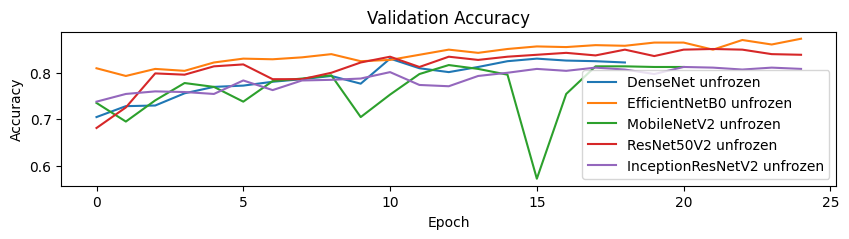

In [ ]:
# Plots the val_accuracy for each unfrozen model with legend
plt.figure(figsize=(10, 2))
for model_name, history_unfrozen in results.items():
    plt.plot(history_unfrozen["val_accuracy"], label=model_name + " unfrozen")
plt.title("Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Conclusion
The EfficientNetB0 model reach the highest accuracy
